# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook series, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The main steps in this notebook series are:


- Notebook 1: Data Ingestion 
    1. Install custom libraries
    2. Load the data 

- Notebook 2:<br>
    3. Understand and process the data through exploratory data analysis and demonstrate the use of Fabric Data Wrangler feature. 

- Notebook 3: <br>
    4. Train machine learning models using `Scikit-Learn` and `LightGBM`, and track experiments using MLflow and Fabric Autologging feature.
    5. Evaluate and save the final machine learning model

- Notebool 4:<br>
	6. load the best model to run predicitons.


    


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

### Imports and parameters

In [1]:
import os
import requests
from pathlib import Path, PurePath, PurePosixPath

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 3, Finished, Available, Finished)

Define these parameters, so that you can use this notebook with different datasets or [Assign parameters values from a pipeline](https://learn.microsoft.com/en-us/fabric/data-engineering/author-execute-notebook#assign-parameters-values-from-a-pipeline).

In [2]:
# Specify the storage location for the data set
DATA_FOLDER = "Files/churn"  # Folder with data files
DATA_FILE = "churn.csv"  # Data file name
TARGET = "Exited" # Dependent (target) attribute
OUTPUT_TABLE_NAME = 'churn'

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 4, Finished, Available, Finished)

## Step 3: Perform exploratory data analysis

### Read raw data from the lakehouse

This code reads raw data from the **Files** section of the lakehouse, and adds more columns for different date parts. Creation of the partitioned delta table uses this information.

In [3]:
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(str(PurePath(DATA_FOLDER, 'raw', DATA_FILE)))
    .cache()
)

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 5, Finished, Available, Finished)

### Create a pandas DataFrame from the dataset

This code converts the Spark DataFrame to a pandas DataFrame, for easier processing and visualization:

In [4]:
df = df.toPandas()

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 6, Finished, Available, Finished)

### Display raw data

Explore the raw data with `display`, calculate some basic statistics, and show chart views. You must first import the required libraries for data visualization - for example, [seaborn](https://seaborn.pydata.org/). Seaborn is a Python data visualization library, and it provides a high-level interface to build visuals on dataframes and arrays.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

sns.set_theme(style="whitegrid", palette="tab10", rc={"figure.figsize": (9, 6)})

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 7, Finished, Available, Finished)

In [6]:
display(df, summary=True)

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2436a248-e6df-434c-9094-1c94dc9b4daa)

### Use Data Wrangler to perform initial data cleaning

Launch Data Wrangler directly from the notebook to explore and transform pandas dataframes. At the notebook ribbon **Data** tab, use the Data Wrangler dropdown prompt to browse the activated pandas DataFrames available for editing. Select the DataFrame you want to open in Data Wrangler.


><mark>NOTE:</mark> \
>Data Wrangler cannot be opened while the notebook kernel is busy. The cell execution must finish before you launch Data Wrangler.
>[Learn more about Data Wrangler](https://aka.ms/fabric/datawrangler).


<br>

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/select_datawrangler.png"  width="40%" height="10%" title="Screenshot shows where to access the Data Wrangler.">

After the Data Wrangler launches, a descriptive overview of the data panel is generated, as shown in the following images. The overview includes information about the dimension of the DataFrame, any missing values, etc. You can use Data Wrangler to generate the script to drop the rows with missing values, the duplicate rows and the columns with specific names. Then, you can copy the script into a cell. The next cell shows that copied script.

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/menu_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler menu."> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/missing_data_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler missing data display.">



```python
# Von Data Wrangler für Pandas DataFrame generierter Code

def clean_data(df):
    # Löschen doppelter Zeilen in Spalten: 'RowNumber', 'CustomerId'
    df = df.drop_duplicates(subset=['RowNumber', 'CustomerId'])
    # Verwerfen von Zeilen mit fehlenden Daten in allen Spalten
    df = df.dropna()
    # Löschen der Spalten: 'RowNumber', 'CustomerId', 'Surname'
    df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
    return df

df_clean = clean_data(df.copy())
df_clean.head()
```

In [7]:
def clean_data(df):
    # Drop duplicate rows
    df = df.drop_duplicates(subset=['RowNumber', 'CustomerId'])
    # Drop rows with any missing data
    df = df.dropna()
    # Drop index columns
    df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
    return df


df_clean = clean_data(df)
df_clean.shape

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 9, Finished, Available, Finished)

(10000, 11)

### Determine attributes

This code determines the categorical, numerical, and target attributes:

In [8]:
# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if df_clean[col].dtype == "O" 
                        or df_clean[col].nunique() <= 5 
                        and col != TARGET ]
print(categorical_variables)
# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if col not in categorical_variables
                    and col != TARGET
]
print(numeric_variables)

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 10, Finished, Available, Finished)

['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


### Show the five-number summary

Show the five-number summary (minimum score, first quartile, median, third quartile, and maximum score) for the numerical attributes by using box plots:

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 11, Finished, Available, Finished)

/tmp/ipykernel_6070/1517057301.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


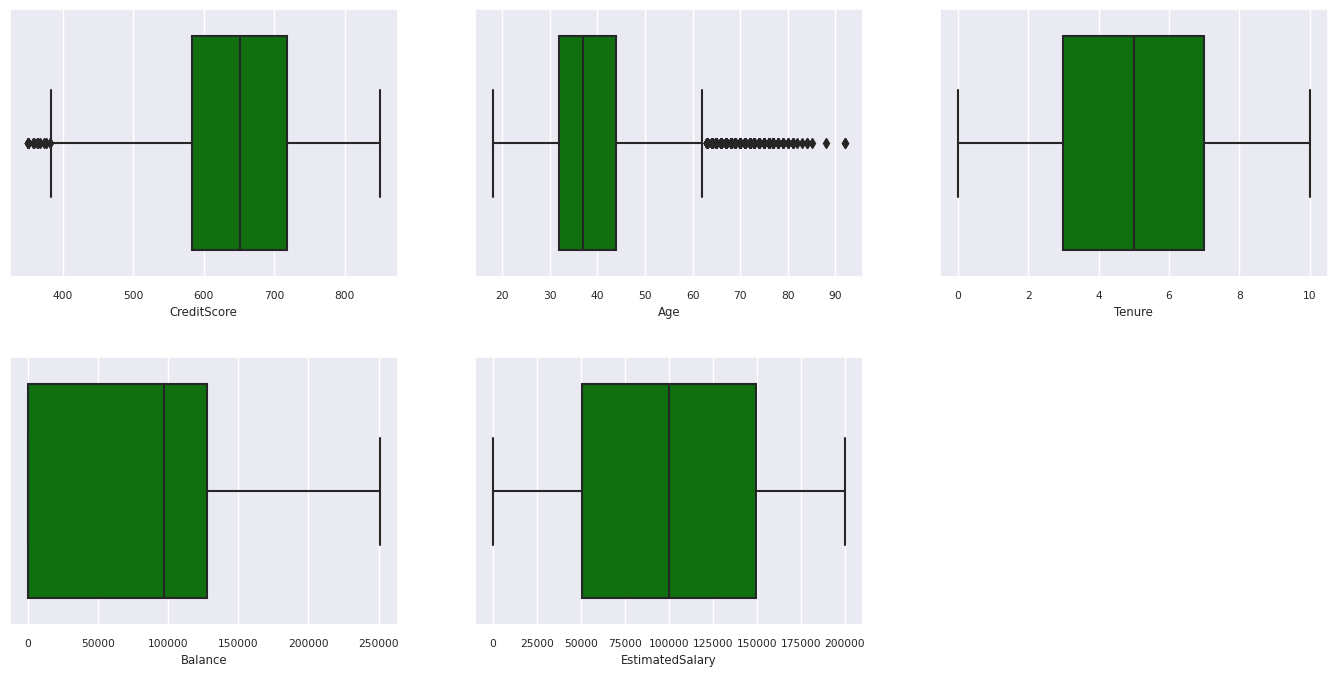

In [9]:
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale=0.7)
fig, axes = plt.subplots(
    nrows=2, ncols=3, gridspec_kw=dict(hspace=0.3), figsize=(17, 8)
)
fig.tight_layout()
for ax, col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x=df_num_cols[col], color="green", ax=ax)
# fig.suptitle('visualize and compare the distribution and central tendency of numerical attributes', color = 'k', fontsize = 12)
fig.delaxes(axes[1, 2])

Show the distribution of exited versus non-exited customers across the categorical attributes:

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 12, Finished, Available, Finished)

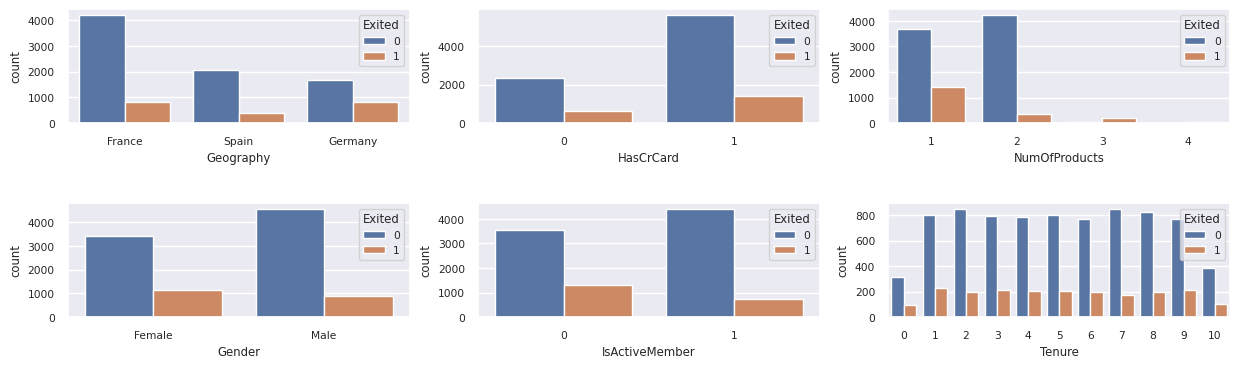

In [10]:
attr_list = [
    "Geography",
    "Gender",
    "HasCrCard",
    "IsActiveMember",
    "NumOfProducts",
    "Tenure",
]
fig, axarr = plt.subplots(2, 3, figsize=(15, 4))
for ind, item in enumerate(attr_list):
    sns.countplot(x=item, hue=TARGET, data=df_clean, ax=axarr[ind % 2][ind // 2])
fig.subplots_adjust(hspace=0.7)

Use a histogram to show the frequency distribution of numerical attributes:

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 13, Finished, Available, Finished)

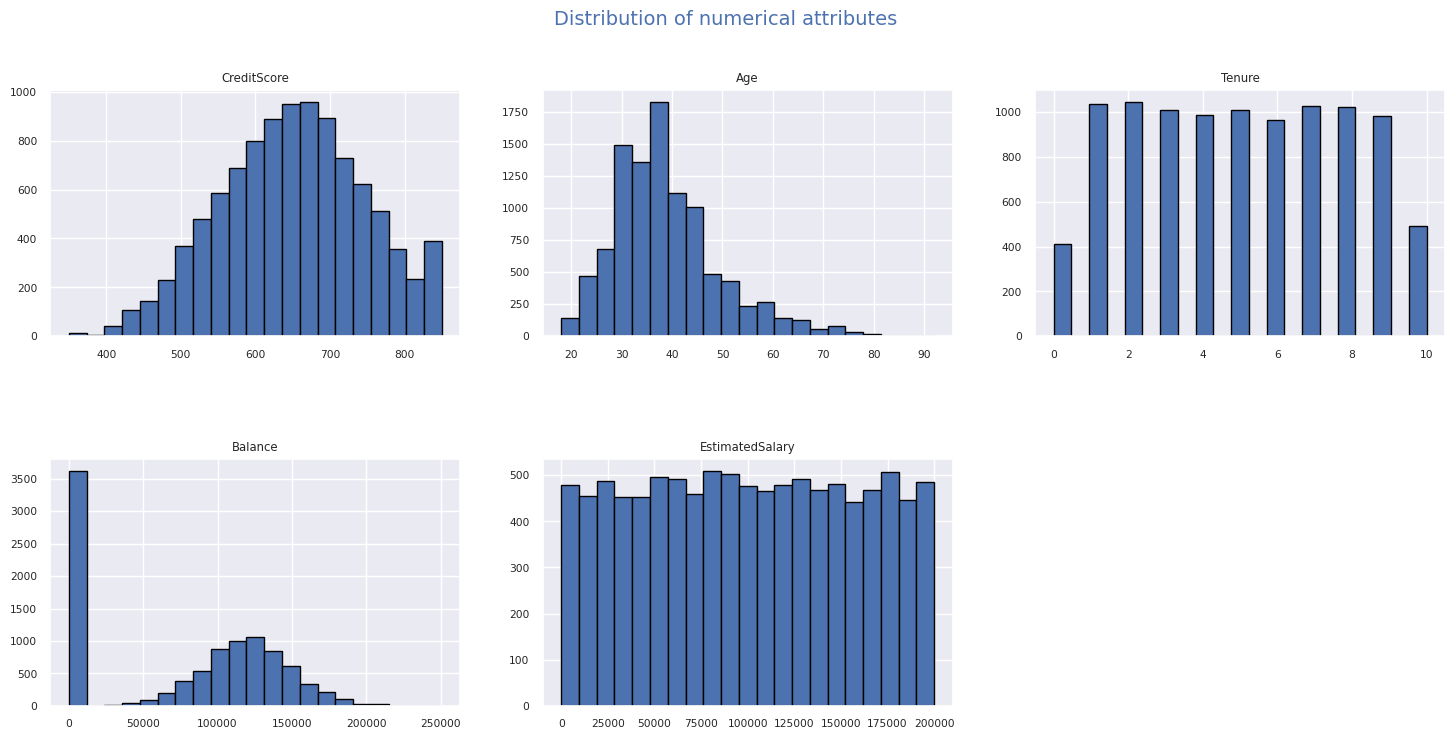

In [11]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(18, 8)
length = len(columns)
for i, j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    df_num_cols[i].hist(bins=21, edgecolor="black")
    plt.title(i)
fig = fig.suptitle('Distribution of numerical attributes', color = 'b' ,fontsize = 14)
plt.show()

### Perform feature engineering 

This feature engineering generates new attributes based on the current attributes:

In [12]:
# limit tenure to time where person is of legal age
df_clean["Tenure"] = np.where((df_clean["Age"]-18) < df_clean["Tenure"], df_clean["Age"]-18, df_clean["Tenure"])
# create a feature tenure telative to age
df_clean["NewTenure"] = np.where(df_clean["Age"] > 18, df_clean["Tenure"]/(df_clean["Age"]-18), 0)

df_clean.describe(include='all')

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 14, Finished, Available, Finished)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure
count,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,4.913400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.302424
std,96.653299,NaN,NaN,10.487806,2.866029,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.244787
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000
25%,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.117647
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.242424
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.411765


### Use Data Wrangler to perform one-hot encoding

With the same steps to launch Data Wrangler, as discussed earlier, use the Data Wrangler to perform one-hot encoding. This cell shows the copied generated script for one-hot encoding:

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows one-hot encoding in the Data Wrangler"> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_selectcolumns_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows selection of columns in the Data Wrangler.">





```python
# Von Data Wrangler für Pandas DataFrame generierter Code

import pandas as pd

def clean_data(df):
    # 1-aus-n-Codierungsspalten: 'Geography', 'Gender'
    for column in ['Geography', 'Gender']:
        insert_loc = df.columns.get_loc(column)
        df = pd.concat([df.iloc[:,:insert_loc], pd.get_dummies(df.loc[:, [column]]), df.iloc[:,insert_loc+1:]], axis=1)
    return df

df_clean = clean_data(df_clean.copy())
df_clean.head()
```

In [13]:
# we use the shorter pandas version
df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

df_clean.describe(include='all')

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 15, Finished, Available, Finished)

### Create a delta table to generate the Power BI report

In [14]:
# Create a PySpark DataFrame from pandas
output_table_name = f"silver/{OUTPUT_TABLE_NAME}"
sparkDF = spark.createDataFrame(df_clean)
sparkDF.write.mode("overwrite").format("delta").save(f"Tables/{output_table_name}")
print(f"Spark DataFrame saved to delta table: {output_table_name}")

StatementMeta(, 76054094-e318-4d49-bf7c-84303397e015, 16, Finished, Available, Finished)

Spark DataFrame saved to delta table: silver/churn


### Summary of observations from the exploratory data analysis

- Most of the customers are from France. Spain has the lowest churn rate, compared to France and Germany.
- Most of the customers have credit cards.
- Some customers are both over the age of 60 and have credit scores below 400. However, they can't be considered as outliers
- Very few customers have more than two of the bank's products.
- Inactive customers have a higher churn rate
- Gender and tenure years have little impact on a customer's decision to close a bank account
